# Estimate Neural Dimensions

This notebook explains how to use the module `dimension` to estimate the dimension (extrinsic or intrinsic) of the neural manifold embedded in neural state space $\mathbb{R}^N$.

In particular, this notebook tests several existing methods of dimension estimation on the synthetic manifolds from the module `datasets.synthetic` to evaluate their performance.

### Set-up + Imports

In [1]:
import setup

setup.main()
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

import os

import matplotlib.pyplot as plt
import numpy as np
import skdim

import neurometry.datasets.synthetic as synthetic
from neurometry.dimension.dimension import (
    plot_dimension_experiments,
    skdim_dimension_estimation,
)

import torch

os.environ["GEOMSTATS_BACKEND"] = "pytorch"
import geomstats.backend as gs

Working directory:  /home/facosta/neurometry/neurometry
Directory added to path:  /home/facosta/neurometry
Directory added to path:  /home/facosta/neurometry/neurometry


INFO:root:Using pytorch backend
INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


### Show Methods Implemented in $\texttt{scikit-dimension}$

In [153]:
all_methods = [method for method in dir(skdim.id) if not method.startswith("_")]
print(all_methods)

['CorrInt', 'DANCo', 'ESS', 'FisherS', 'KNN', 'MADA', 'MLE', 'MOM', 'MiND_ML', 'TLE', 'TwoNN', 'lPCA']


### Define Parameters for Experiments

In [150]:
num_points = 2000
num_neurons = 40
max_id_dim = 20
dimensions = [_ for _ in range(1, max_id_dim + 1)]
methods = ["MLE", "lPCA", "TwoNN", "CorrInt"]
poisson_multiplier = 1
num_trials = 20
ref_frequency = 50

### Run Experiments for Hyperspheres with $\texttt{scikit-dimension}$

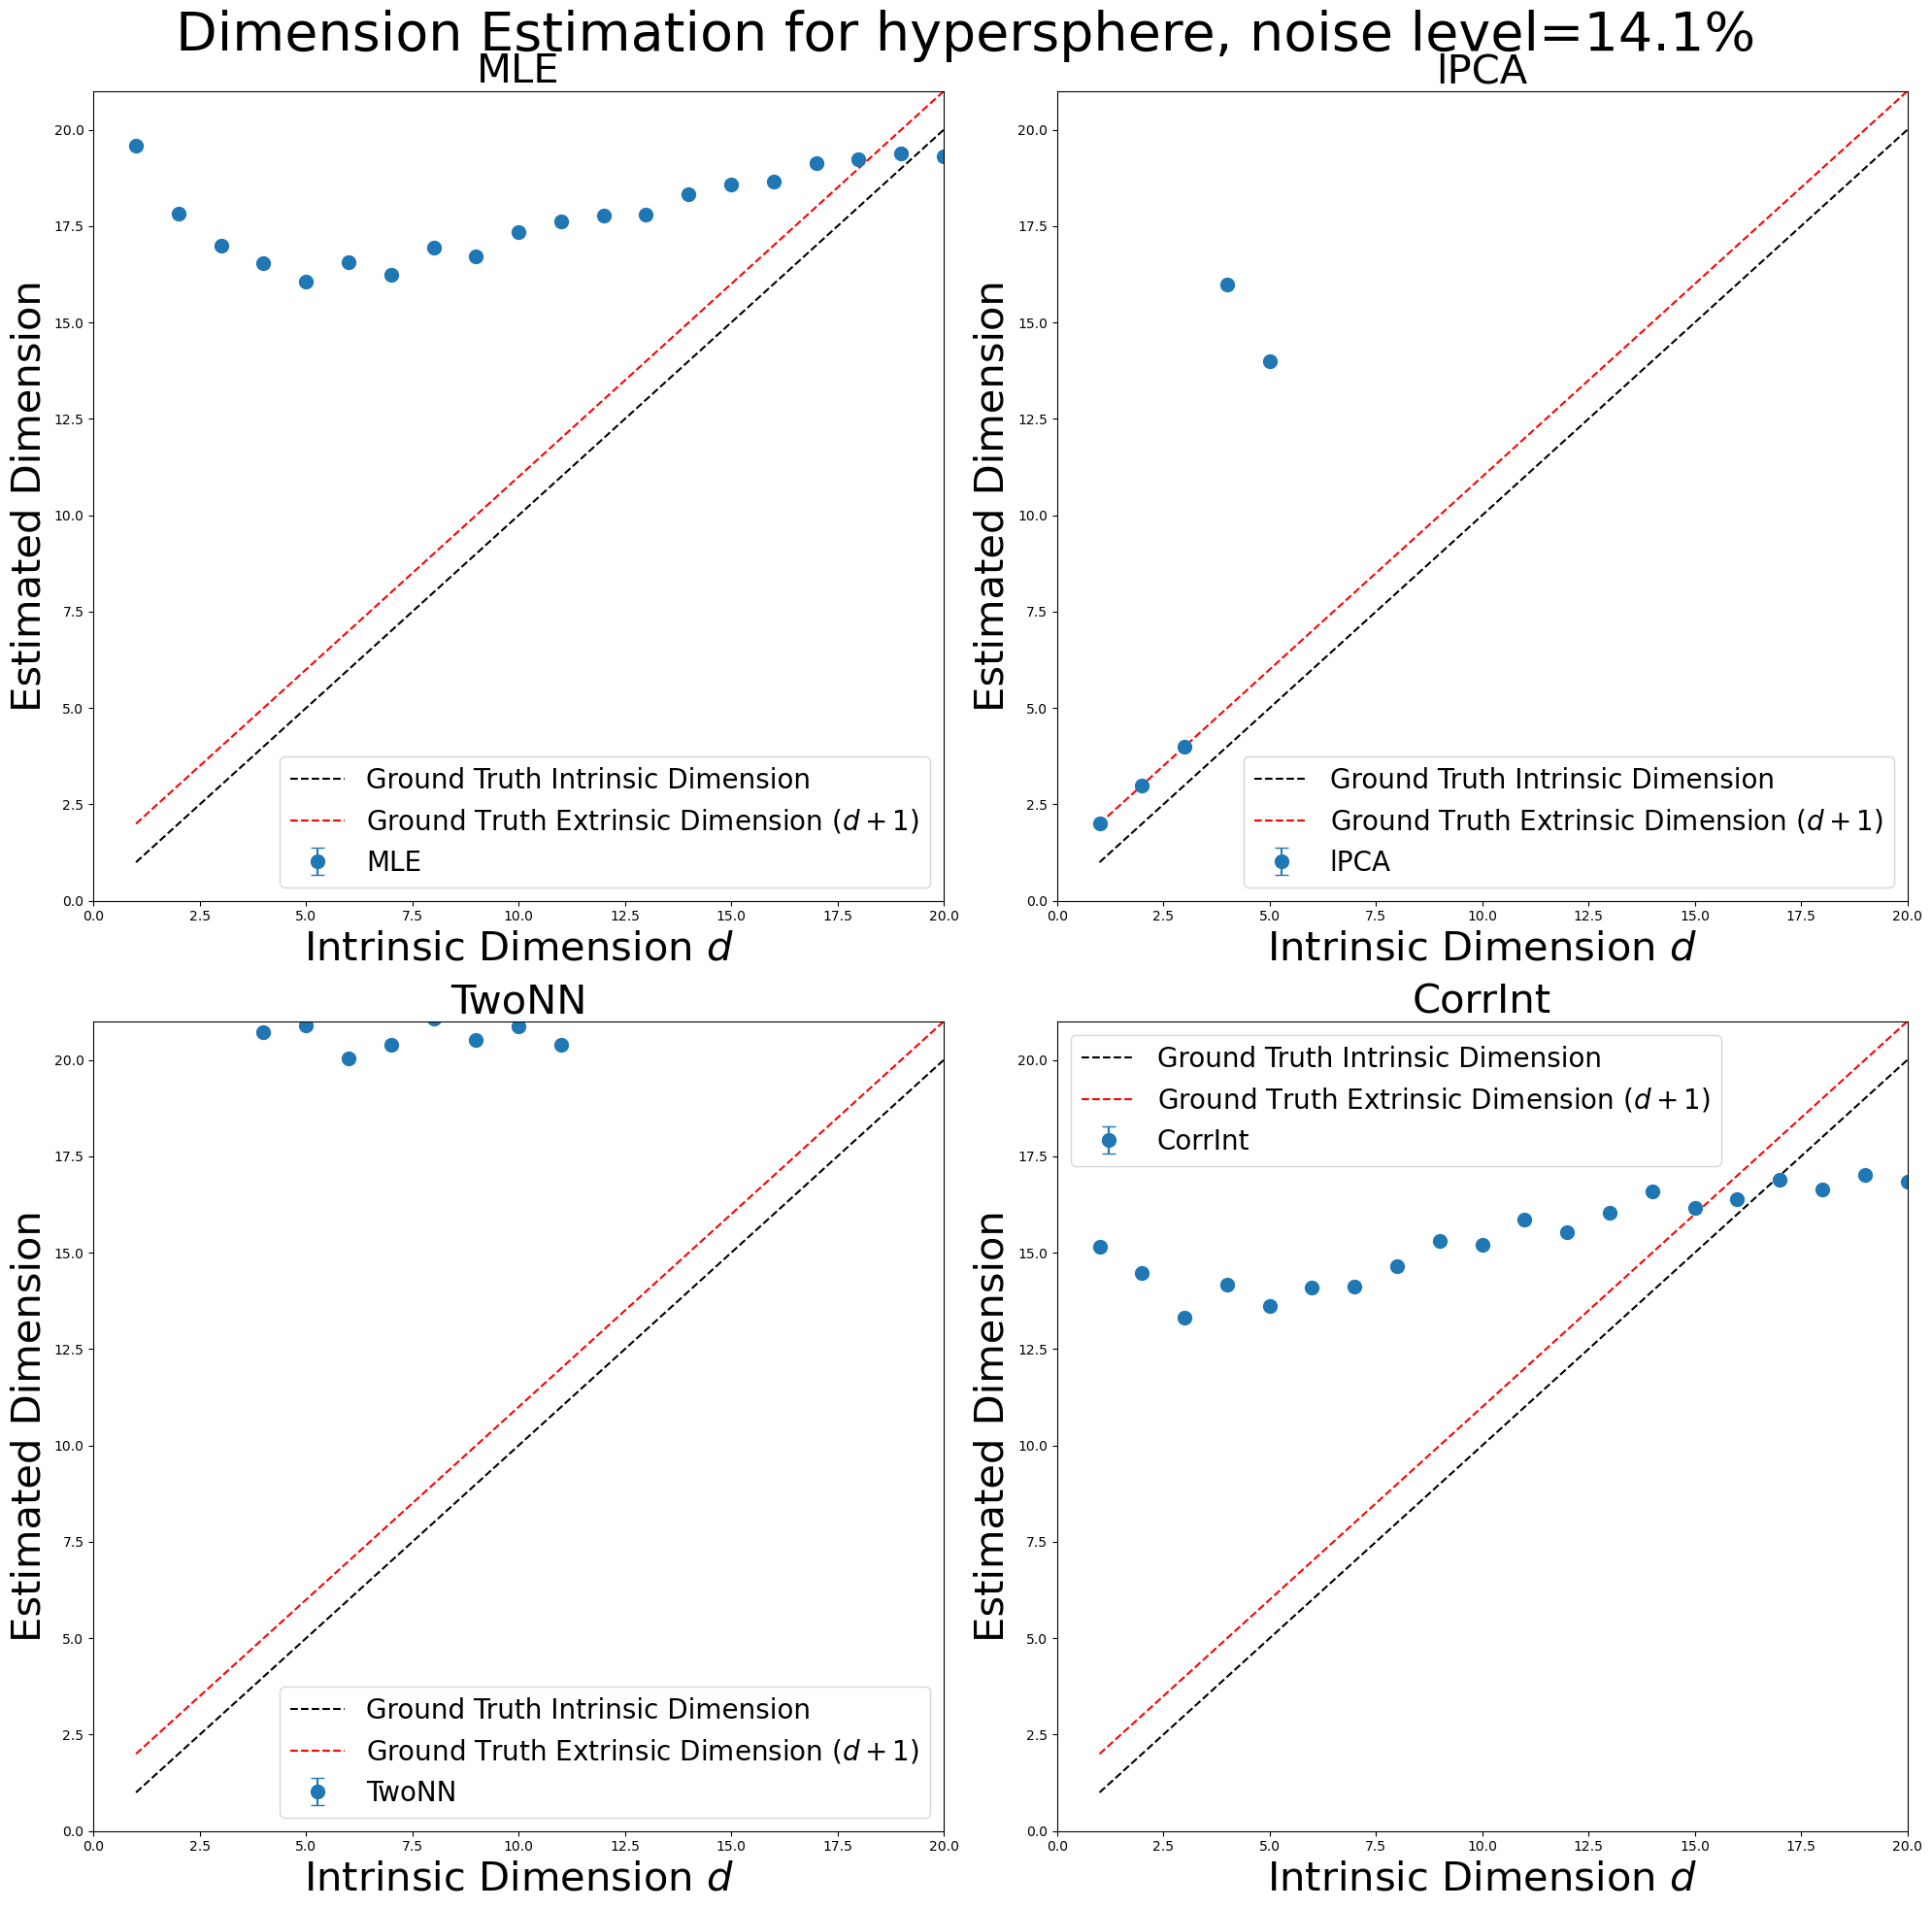

In [151]:
manifold_type = "hypersphere"
id_estimates_hyperspheres, noise_level = skdim_dimension_estimation(
    methods,
    dimensions,
    manifold_type,
    num_trials,
    num_points,
    num_neurons,
    poisson_multiplier,
    ref_frequency,
)
plot_dimension_experiments(
    id_estimates_hyperspheres, dimensions, max_id_dim, manifold_type, noise_level
)

### Run Experiments for Hypertori with $\texttt{scikit-dimension}$

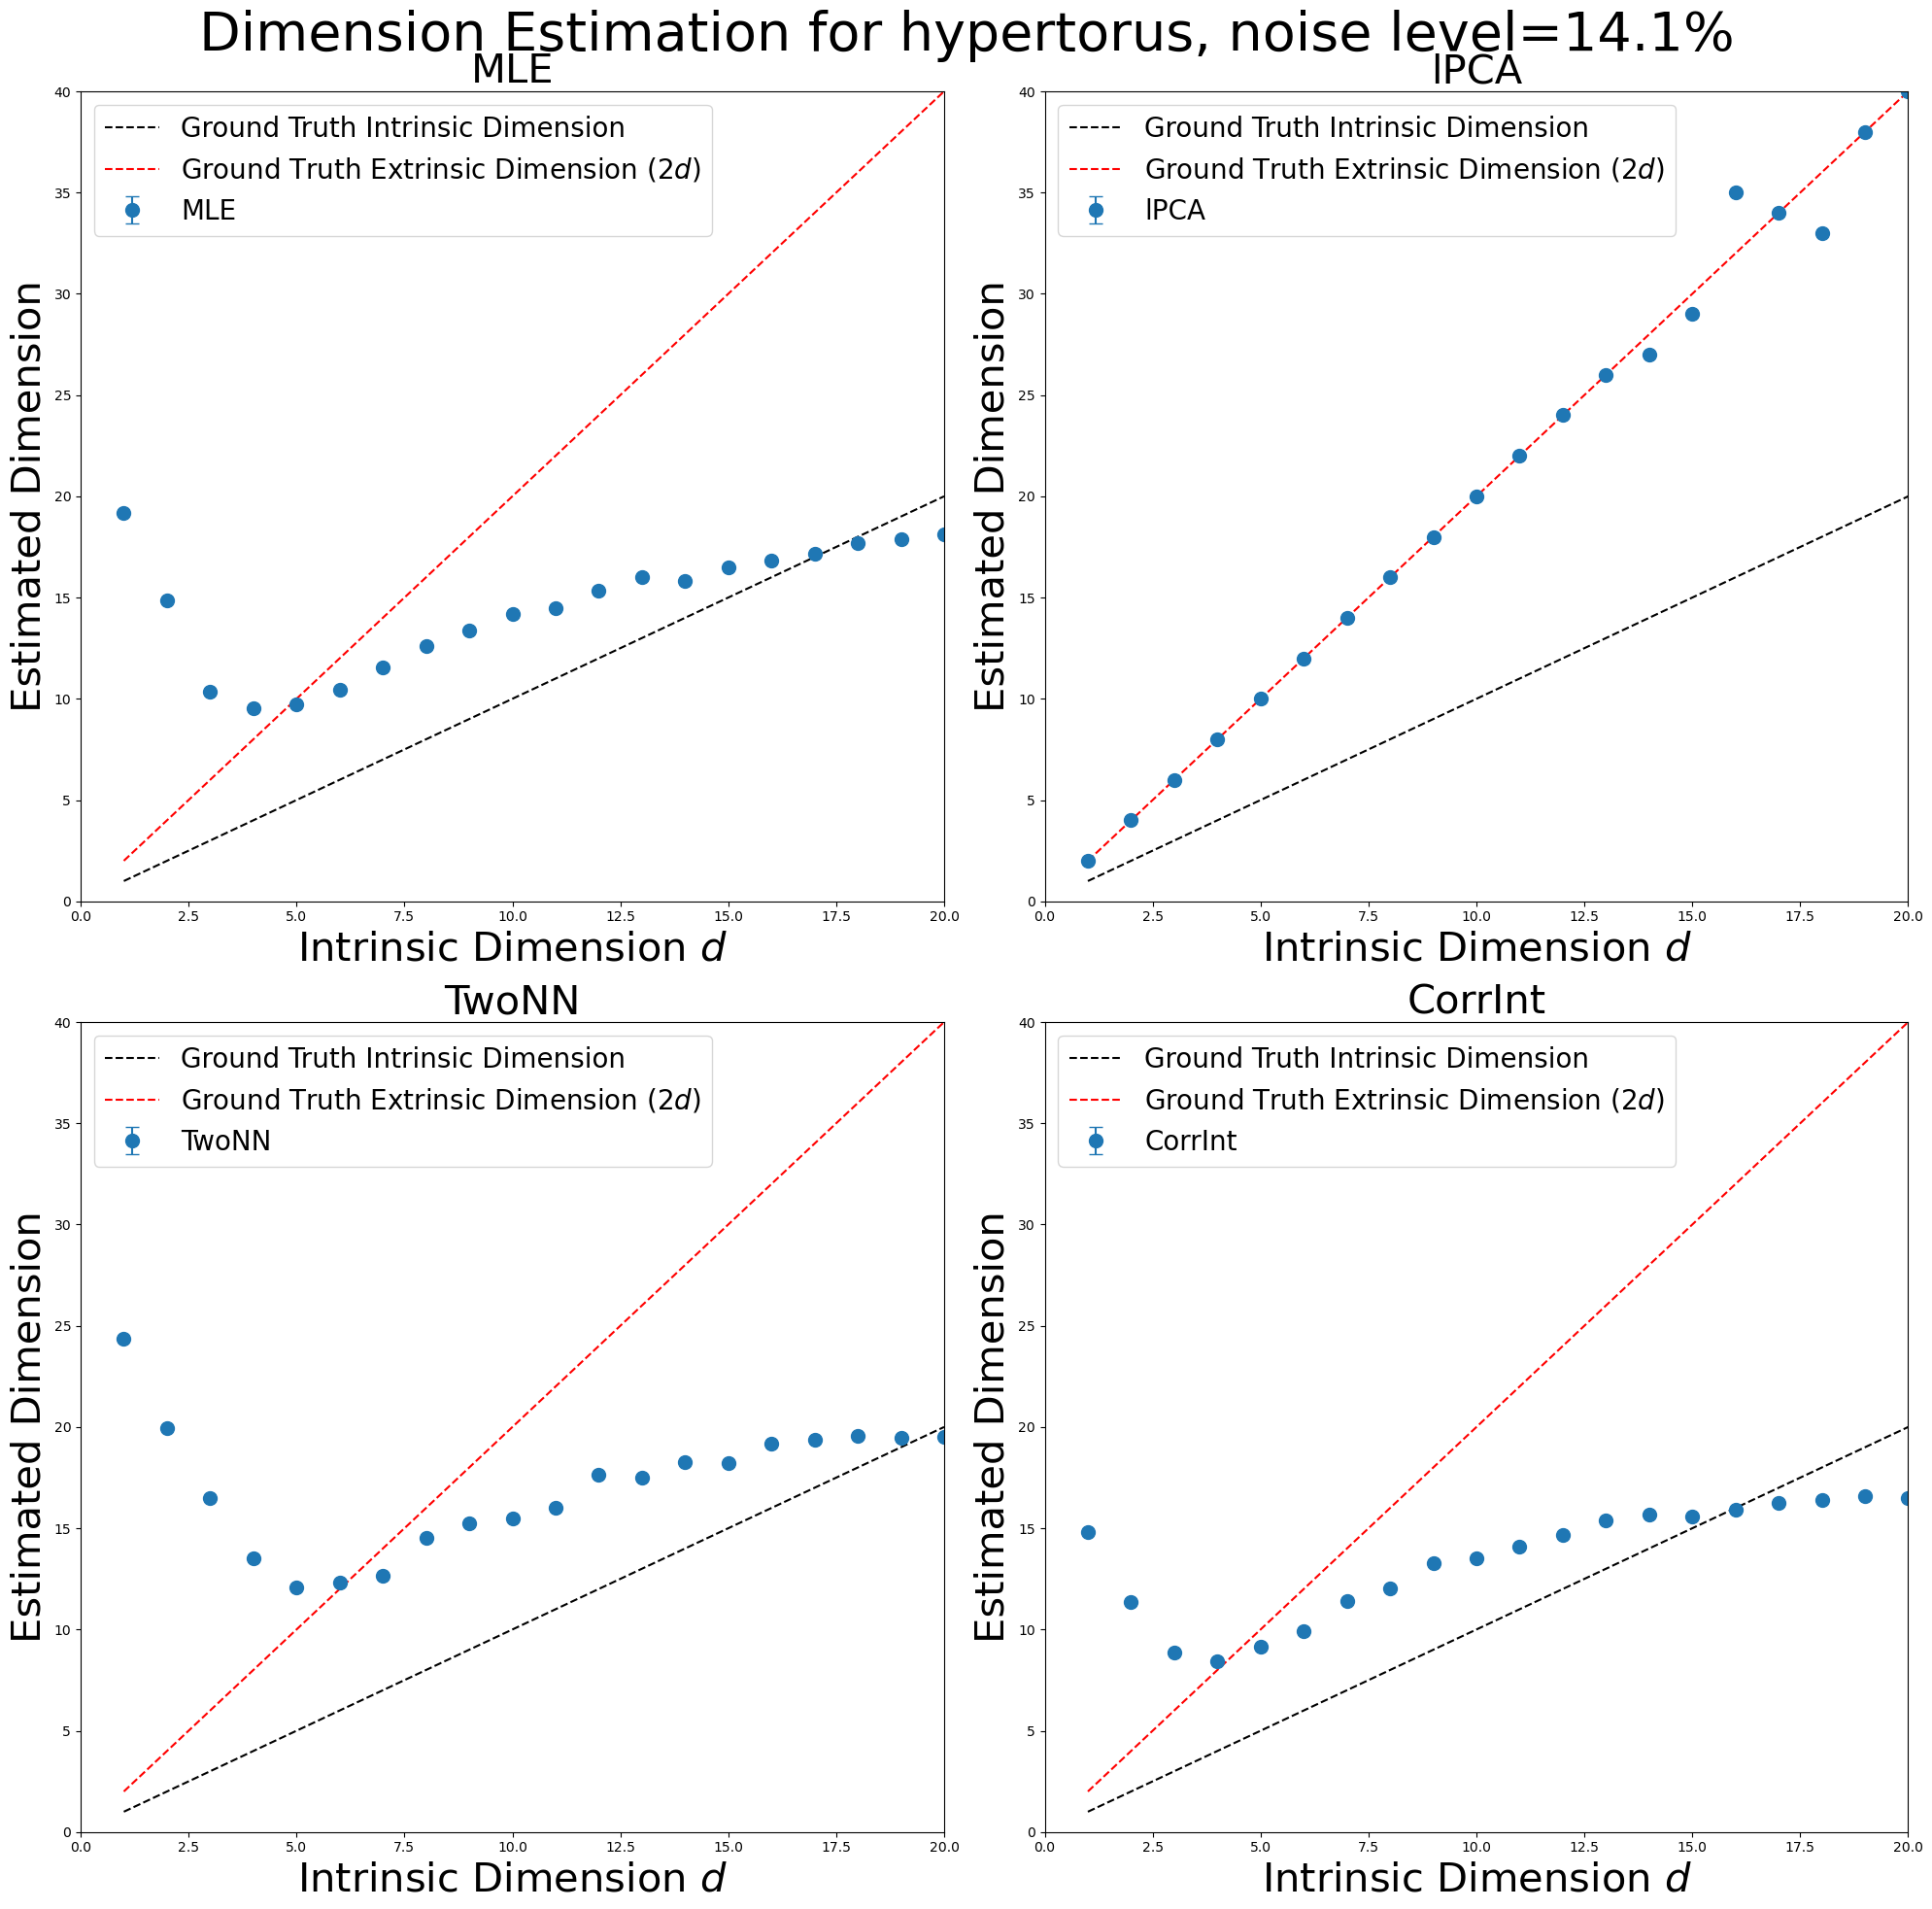

In [152]:
manifold_type = "hypertorus"
id_estimates_hypertori, noise_level = skdim_dimension_estimation(
    methods,
    dimensions,
    manifold_type,
    num_trials,
    num_points,
    num_neurons,
    poisson_multiplier,
    ref_frequency,
)
plot_dimension_experiments(
    id_estimates_hypertori, dimensions, max_id_dim, manifold_type, noise_level
)

### Try Single Experiment

In [8]:
num_points = 2000
num_neurons = 40
poisson_multiplier = 1
num_trials = 50
ref_frequency = 50
manifold_type = "hypertorus"


point_generator = getattr(synthetic, manifold_type)
points = point_generator(intrinsic_dim=1, num_points=num_points)
neural_manifold, _ = synthetic.synthetic_neural_manifold(
    points,
    num_neurons,
    "sigmoid",
    poisson_multiplier,
    ref_frequency,
    scales=gs.ones(num_neurons),
)

In [9]:
neural_manifold.shape

torch.Size([2000, 40])

In [217]:
method_name = "KNN"

method = getattr(skdim.id, method_name)()

estimates = np.zeros(num_trials)

for trial_idx in range(num_trials):
    method.fit(neural_manifold)
    estimates[trial_idx] = np.mean(method.dimension_)

print(estimates)

[ 2.  2.  3.  5.  2.  2.  4.  2.  2.  2.  2. 17.  4.  2. 40.  2.  2.  2.
  5.  3.  2.  2.  2.  3. 40.  2.  2. 11. 10.  5. 40.  2.  4.  4. 38.  3.
  3.  3.  1.  3.  2. 40.  2.  3.  2.  7.  2.  9.  2.  2.]


try: find median/mode of KNN algorithm

In [218]:
torch.median(torch.tensor(estimates))

tensor(2.)

try: first PCA data down to minimal embedding dim, then nonlinear dim est

## PLS approach

In [48]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor


def evaluate_pls_with_different_K(X, Y, K_values):
    """
    Evaluate PLS Regression followed by Multi-Output Regression for different numbers of components (K).

    Parameters:
    - X: Neural activity data (predictors)
    - Y: Continuous 2D outcomes
    - K_values: A list of integers representing different numbers of PLS components to evaluate

    Returns:
    - A list of R^2 scores corresponding to each K-value
    """
    r2_scores = []
    projected_X = []

    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42
    )

    for K in K_values:
        # Initialize and fit PLS Regression
        pls = PLSRegression(n_components=K)
        pls.fit(X_train, Y_train)

        # Project both training and test data using the PLS model
        X_train_pls = pls.transform(X_train)
        X_test_pls = pls.transform(X_test)
        projected_X.append(pls.inverse_transform(X_test_pls))

        # Fit the Multi-Output Regression model on the reduced data
        multi_output_reg = MultiOutputRegressor(LinearRegression()).fit(
            X_train_pls, Y_train
        )

        # Predict and evaluate using R^2 score
        Y_pred = multi_output_reg.predict(X_test_pls)
        score = r2_score(
            Y_test, Y_pred, multioutput="uniform_average"
        )  # Average R^2 score across all outputs
        r2_scores.append(score)

    return r2_scores, projected_X

In [49]:
from sklearn.decomposition import PCA


def evaluate_PCA_with_different_K(X, Y, K_values):
    """
    Evaluate PCA for different numbers of components (K).

    Parameters:
    - X: Data to perform PCA on
    - K_values: A list of integers representing different numbers of PCA components to evaluate

    Returns:
    - A list of R^2 scores corresponding to each K-value
    """
    r2_scores = []
    projected_X = []

    # Split data into training and test sets

    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42
    )

    for K in K_values:
        # Initialize and fit PCA
        pca = PCA(n_components=K)
        pca.fit(X_train)

        # Project both training and test data using the PCA model
        X_train_pca = pca.transform(X_train)
        X_test_pca = pca.transform(X_test)
        projected_X.append(pca.inverse_transform(X_test_pca))

        # Fit the Multi-Output Regression model on the reduced data
        multi_output_reg = MultiOutputRegressor(LinearRegression()).fit(
            X_train_pca, Y_train
        )

        # Predict and evaluate using R^2 score
        Y_pred = multi_output_reg.predict(X_test_pca)
        score = r2_score(
            Y_test, Y_pred, multioutput="uniform_average"
        )  # Average R^2 score across all outputs
        r2_scores.append(score)

    return r2_scores, projected_X

In [65]:
import numpy as np
from sklearn.model_selection import KFold


def evaluate_PCA_with_different_K_cv(X, Y, K_values, n_splits=5):
    """
    Evaluate PCA for different numbers of components (K) using cross-validation.

    Parameters:
    - X: Data to perform PCA on
    - Y: Continuous 2D outcomes
    - K_values: A list of integers representing different numbers of PCA components to evaluate
    - n_splits: Number of folds in K-Fold cross-validation

    Returns:
    - A dictionary of R^2 scores for each K-value, each containing a list of scores for each fold
    """
    cv_scores = {
        K: [] for K in K_values
    }  # Initialize dictionary to store scores for each K

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for K in K_values:
        # Loop through each fold defined by KFold
        for train_index, test_index in kf.split(X):
            # Split data into training and test sets for this fold
            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]

            # Initialize and fit PCA
            pca = PCA(n_components=K)
            pca.fit(X_train)

            # Project both training and test data using the PCA model
            X_train_pca = pca.transform(X_train)
            X_test_pca = pca.transform(X_test)

            # Fit the Multi-Output Regression model on the reduced data
            multi_output_reg = MultiOutputRegressor(LinearRegression()).fit(
                X_train_pca, Y_train
            )

            # Predict and evaluate using R^2 score
            Y_pred = multi_output_reg.predict(X_test_pca)
            score = r2_score(Y_test, Y_pred, multioutput="uniform_average")
            cv_scores[K].append(score)

    return cv_scores

In [66]:
import numpy as np


def evaluate_pls_with_different_K_cv(X, Y, K_values, n_splits=5):
    """
    Evaluate PLS Regression followed by Multi-Output Regression for different numbers of components (K)
    using cross-validation.

    Parameters:
    - X: Neural activity data (predictors)
    - Y: Continuous 2D outcomes
    - K_values: A list of integers representing different numbers of PLS components to evaluate
    - n_splits: Number of folds in K-Fold cross-validation

    Returns:
    - A dictionary of R^2 scores for each K-value, each containing a list of scores for each fold
    """
    cv_scores = {
        K: [] for K in K_values
    }  # Initialize dictionary to store scores for each K

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for K in K_values:
        # Loop through each fold defined by KFold
        for train_index, test_index in kf.split(X):
            # Split data into training and test sets for this fold
            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]

            # Initialize and fit PLS Regression
            pls = PLSRegression(n_components=K)
            pls.fit(X_train, Y_train)

            # Project both training and test data using the PLS model
            X_train_pls = pls.transform(X_train)
            X_test_pls = pls.transform(X_test)

            # Fit the Multi-Output Regression model on the reduced data
            multi_output_reg = MultiOutputRegressor(LinearRegression()).fit(
                X_train_pls, Y_train
            )

            # Predict and evaluate using R^2 score
            Y_pred = multi_output_reg.predict(X_test_pls)
            score = r2_score(
                Y_test, Y_pred, multioutput="uniform_average"
            )  # Average R^2 score across all outputs
            cv_scores[K].append(score)

    return cv_scores

In [90]:
import neurometry.datasets.synthetic as synthetic

N = 20

task_points = synthetic.hypertorus(2, 500)
noisy_points, manifold_points = synthetic.synthetic_neural_manifold(
    points=task_points,
    encoding_dim=N,
    nonlinearity="sigmoid",
    poisson_multiplier=1,
    scales=gs.array(np.random.uniform(1, 3, N)),
)

noise level: 7.07%


In [91]:
import numpy as np
import torch


def add_noise_dimensions(data, n_dims):
    """
    Adds a column of random noise to the input data.

    Parameters:
    - data: A numpy array of shape (num_points, dim), where `num_points` is the number of data points
            and `dim` is the dimensionality of each data point.
    - noise_scale: The standard deviation of the Gaussian noise to be added. Default is 1.0.

    Returns:
    - A numpy array of shape (num_points, dim+1), where the last column is filled with random noise.
    """
    num_points, dim = data.shape
    noise = np.random.normal(
        loc=torch.mean(data), scale=1.5 * torch.std(data), size=(num_points, n_dims)
    )
   
    noisy_data = np.hstack((data, noise))

    return noisy_data

torch.Size([500, 20])
(500, 40)


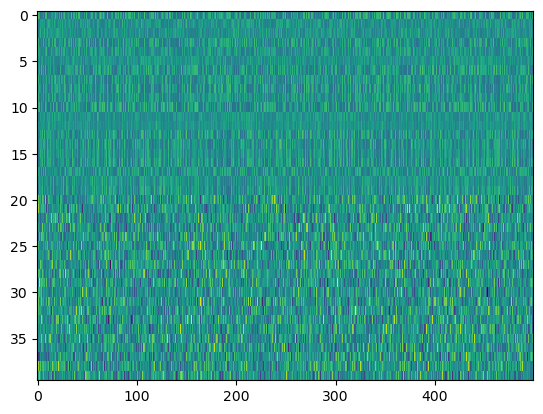

In [92]:
X = add_noise_dimensions(noisy_points, n_dims=N)
Y = task_points

print(noisy_points.shape)
print(X.shape)

plt.imshow(X.T, aspect="auto", interpolation="None");

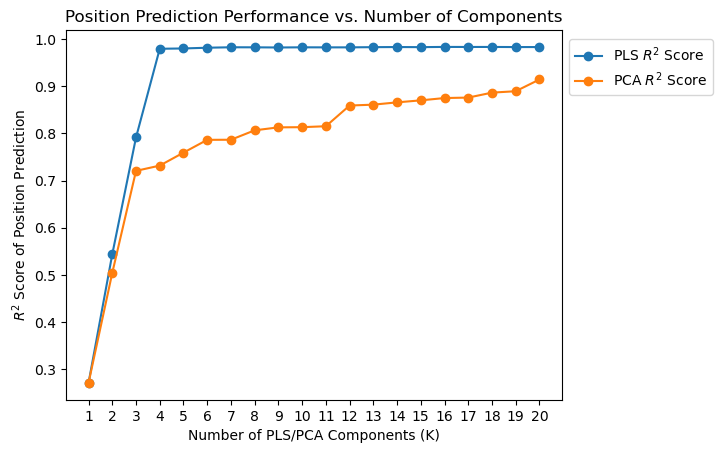

In [93]:
K_values = [i for i in range(1, N + 1)]

pls_r2_scores, pls_transformed_X = evaluate_pls_with_different_K(X, Y, K_values)

pca_r2_scores, pca_transformed_X = evaluate_PCA_with_different_K(X, Y, K_values)

plt.plot(K_values, pls_r2_scores, marker="o", label="PLS $R^2$ Score")

plt.plot(K_values, pca_r2_scores, marker="o", label="PCA $R^2$ Score")

# pls_cv_scores = evaluate_pls_with_different_K_cv(X, Y, K_values, n_splits=5)

# pca_cv_scores = evaluate_PCA_with_different_K_cv(X, Y, K_values, n_splits=5)


# plt.errorbar(
#     K_values,
#     np.mean(list(pls_cv_scores.values()), axis=1),
#     yerr=np.std(list(pls_cv_scores.values()), axis=1),
#     fmt="-o",
#     label="PLS R^2 Score",
# )

# plt.errorbar(
#     K_values,
#     np.mean(list(pca_cv_scores.values()), axis=1),
#     yerr=np.std(list(pca_cv_scores.values()), axis=1),
#     fmt="-o",
#     label="PCA R^2 Score",
# )

plt.xticks(K_values)
plt.xlabel("Number of PLS/PCA Components (K)")
plt.ylabel("$R^2$ Score of Position Prediction")
plt.title("Position Prediction Performance vs. Number of Components")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.9));